### Aim to training the bi-GRU as decoder
#### the right dashed box in the flowchart
<img src="../model_structure.jpg" alt="model_structure" width="600" />

In [12]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('../models'))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.nn.parameter import Parameter

# import math
# import argparse
from torch.utils.data import Dataset,DataLoader,random_split,TensorDataset
import numpy as np
import matplotlib.pyplot as plt


#### The training data can be generated from [training_dcae.ipynb](./training_dcae.ipynb) or directly from here.

In [15]:
#########################
#data from DCAE
##########################
from DCAE import Autoencoder
from gaps_generation import ge_unsche

sig=np.load("../sig_toy_signal.npy")
original_data = torch.from_numpy(sig)

# Create an instance of the autoencoder
autoencoder = torch.load('../models/models_dcae.pth')

### Setting the time range
tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

####################################
# get data ready for RNN training
####################################
#data for rnn
sigrnn=original_data[::5,:]

inputrnn= np.zeros((200,51840))
targetrnn=np.zeros((200,51840))
for i in range(200):
    mask=ge_unsche(t)
    snodata0,normaldata0,mean0,std0= autoencoder.signal_preprocess(sigrnn[i].reshape(1,1,-1),mask)
    outputs0=autoencoder(snodata0)
    inputrnn0=outputs0.detach().numpy()
    inputrnn[i]=inputrnn0.reshape(1,-1)
    targetrnn0=normaldata0.detach().numpy()
    targetrnn[i]=targetrnn0.reshape(1,-1)
    

np.max(np.abs(targetrnn))


1.4177132751742416

In [16]:
#putdown to -1,1
output_normalized_sig=torch.tensor(targetrnn/1.5)
normalized_sig=torch.tensor(inputrnn)

output_normalized_sig.shape

torch.Size([200, 51840])

In [17]:
normalized_sig=normalized_sig.reshape((-1,48,1)).float()
output_normalized_sig=output_normalized_sig.reshape((-1,48,1)).float()

from sklearn.model_selection import train_test_split
import random

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(range(len(normalized_sig)), test_size=0.2, random_state=42)

# Convert the sequences to PyTorch tensors
train_input_sequences = normalized_sig[train_indices]
train_output_sequences = output_normalized_sig[train_indices]
# print(train_input_sequences .shape)
# print(train_output_sequences .shape)

# Create a TensorDataset and DataLoader for training data
train_dataset = TensorDataset(train_input_sequences, train_output_sequences)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Convert the sequences to PyTorch tensors
test_input_sequences = normalized_sig[test_indices]
test_output_sequences = output_normalized_sig[test_indices]
# print(test_input_sequences .shape)
# print(test_output_sequences .shape)

# Create a TensorDataset and DataLoader for training data
test_dataset = TensorDataset(train_input_sequences, train_output_sequences)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [18]:
######################
#BI_GRU import
######################
from bi_GRU import BidirectionalGRUModel

# Model Initialization
input_size = 1
hidden_size = 12
output_size = 1
model = BidirectionalGRUModel(input_size, hidden_size, output_size)

# Print the autoencoder architecture
print(model)

BidirectionalGRUModel(
  (gru): GRU(1, 12, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Tanh()
  (fc1): Linear(in_features=24, out_features=1, bias=True)
)


In [15]:
torch.set_num_threads(8)

################
#Model Training
################
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
test_loss=np.zeros(50)
for epoch in range(num_epochs):
    running_loss = 0.0
    runningtest_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

    # Model Evaluation
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            # Calculate evaluation metrics
            loss = criterion(outputs, targets)
            runningtest_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {runningtest_loss / len(test_loader)}")
        test_loss[epoch]=runningtest_loss / len(test_loader)
    
print("Training finished!")


Epoch 1/50, Loss: 0.028357649974145548
Epoch 1/50, Loss: 0.003105797424602012
Epoch 2/50, Loss: 0.0019125643086024663
Epoch 2/50, Loss: 0.0013584887097305102
Epoch 3/50, Loss: 0.0011841414886509516
Epoch 3/50, Loss: 0.0010754102098332993
Epoch 4/50, Loss: 0.0009563162513896478
Epoch 4/50, Loss: 0.0008056527616335424
Epoch 5/50, Loss: 0.0008283417556473675
Epoch 5/50, Loss: 0.0007159051134712407
Epoch 6/50, Loss: 0.0007390945258925462
Epoch 6/50, Loss: 0.0006821393927330737
Epoch 7/50, Loss: 0.0006782232645976667
Epoch 7/50, Loss: 0.0006182449366261372
Epoch 8/50, Loss: 0.0006257905649599033
Epoch 8/50, Loss: 0.0005996372883695316
Epoch 9/50, Loss: 0.0005918079278112769
Epoch 9/50, Loss: 0.0006237906573396348
Epoch 10/50, Loss: 0.0005636398646014708
Epoch 10/50, Loss: 0.0005171249897210617
Epoch 11/50, Loss: 0.0005322936931366308
Epoch 11/50, Loss: 0.0006787382459690518
Epoch 12/50, Loss: 0.0005170121073347723
Epoch 12/50, Loss: 0.00048794998441870253
Epoch 13/50, Loss: 0.00049813983664

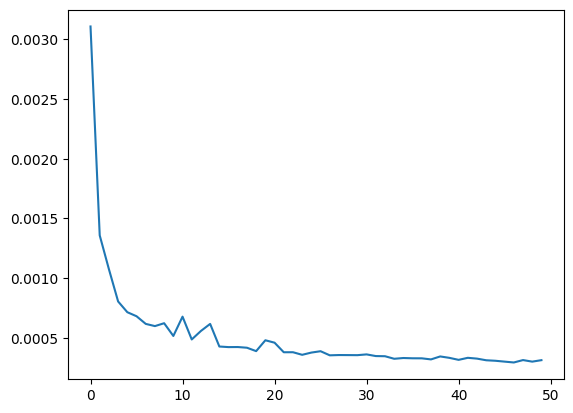

In [16]:
plt.plot(test_loss)

In [17]:
torch.save(model, "../models/models_ae_gru.pth")
print("save model")

save model
